In [32]:
# -*- coding: utf-8 -*-

import scipy.io
import numpy as np
import tensorflow as tf
import sklearn as sk
import matplotlib.pyplot as plt
import itertools
import random

from numba import cuda
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import  EarlyStopping

In [33]:
# tensorflow = 2.
# python = 3.6


seed = np.random.seed(777)

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    
  try:
      
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      
  except RuntimeError as e:
      
    print(e)


val_loss_all = []

test_loss_all = []
test_acc_all = []
test_pre_all = []
frr_all = []
far_all = []

conf_matrix_sco = []
test_pre_sco = []
test_rec_sco = []
test_spedi_sco = []
test_sensi_sco = []

class MyModelCheckpoint(tf.keras.callbacks.ModelCheckpoint):

    def __init__(self, *args, **kwargs):
        super(MyModelCheckpoint, self).__init__(*args, **kwargs)

    # redefine the save so it only activates after 100 epochs
    def on_epoch_end(self, epoch, logs=None):
        if epoch >= 1: super(MyModelCheckpoint, self).on_epoch_end(epoch, logs)

In [34]:
train_data = scipy.io.loadmat('../../datas/160hz/train_5day_160hz.mat', squeeze_me=True)['data']
test_data = scipy.io.loadmat('../../datas/160hz/test_6day_160hz(2).mat', squeeze_me=True)['data']

# sub 수
sub_cnt = train_data.shape[0]

# 3sec 데이터 크기
data_size = 480

# 1명당 3초 데이터 개수
train_data_cnt = 1052
test_data_cnt = 211

# 3sec 480(= 160*3) 크기로 데이터 길이 설정
train_cut_size = 504960 # 480*1052 = 504960
test_cut_size = 101280 # 480*211 = 101280

# 3sec 데이터 길이 자르기
# train: 504,960 / test: 101,280
train_data = train_data[:,0:train_cut_size,:]
test_data = test_data[:,0:test_cut_size,:]

# flatten(): 3D -> 1D / reshape(-1,1): -1 마지막 인덱스
train_flatten = train_data.flatten().reshape(-1,1)
test_flatten = test_data.flatten().reshape(-1,1)

# StandardScaler(): train에 맞춰 표준화
data_scaler = StandardScaler()
    
data_scaler.fit(train_flatten)
train_scaler = data_scaler.transform(train_flatten)
test_scaler = data_scaler.transform(test_flatten)
    
# train, test 데이터 reshape
train_data = train_scaler.reshape(train_data_cnt * sub_cnt, data_size, 2) 
test_data = test_scaler.reshape(test_data_cnt * sub_cnt, data_size, 2)

#train data를 sub:other=1:1로 만들기 위해서 각 sub 추출
train_data_each = []
for i in range(sub_cnt):
    train_data_each.insert(i, train_data[i*train_data_cnt:(i+1)*train_data_cnt, :, :])
print(np.shape(train_data_each))

#test data를 sub:other=1:3로 만들기 위해서 각 sub 추출
test_data_each = []
for i in range(sub_cnt):
    test_data_each.insert(i, test_data[i*test_data_cnt:(i+1)*test_data_cnt, :, :])
print(np.shape(test_data_each))

(11, 1052, 480, 2)
(11, 211, 480, 2)


In [35]:
# sub number
sub_num = 4

#1 to 3 비율로 설정
ratio = 3

train_data_n = train_data_each[sub_num]
test_data_n = test_data_each[sub_num]

# train data를 sub:other = 1:3으로 만들기
# 3초 덩어리 개수 1052 : 3156
# => 315 * 4 + 316 * 6 = 1260 + 1896 = 3156

# test data를 sub:other = 1:3로 만들기
# 3초 덩어리 개수 211 : 633
# 63 * 7 + 64 * 3 = 633

cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 4:
        cnt = cnt + 1
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 315)), axis = 0)
    elif j != sub_num and cnt >= 4:
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 316)), axis = 0)
#     print("train_data_n.shape")
#     print(train_data_n.shape)
#     print("train_data_n")
#     print(train_data_n)
        
cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 7:
        cnt = cnt + 1
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 63)), axis = 0)
    elif j != sub_num and cnt >= 7:
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 64)), axis = 0)
        
        
        
train_label = np.zeros(train_data_cnt*(ratio+1))
test_label = np.zeros(test_data_cnt*(ratio+1))

for j in range(len(train_label)):
    if (j < train_data_cnt):
        train_label[j] = 1

for j in range(len(test_label)):
    if (j < test_data_cnt):
        test_label[j] = 1
        
train_data_shuffled, train_label_shuffled = sk.utils.shuffle(train_data_n, train_label, random_state = 0)

val_data_set = train_data_shuffled[:train_data_cnt]
train_data_set = train_data_shuffled[train_data_cnt:]

val_label_set = train_label_shuffled[:train_data_cnt]
train_label_set = train_label_shuffled[train_data_cnt:]
  

Epoch 1/200
99/99 [==============================] - 6s 59ms/step - loss: 0.5650 - accuracy: 0.7544 - val_loss: 0.5737 - val_accuracy: 0.7367
Epoch 2/200
99/99 [==============================] - ETA: 0s - loss: 0.5575 - accuracy: 0.7544
Epoch 00002: val_loss improved from inf to 0.57416, saving model to best_model_5.h5
99/99 [==============================] - 6s 58ms/step - loss: 0.5575 - accuracy: 0.7544 - val_loss: 0.5742 - val_accuracy: 0.7367
Epoch 3/200
99/99 [==============================] - ETA: 0s - loss: 0.5533 - accuracy: 0.7544
Epoch 00003: val_loss improved from 0.57416 to 0.56395, saving model to best_model_5.h5
99/99 [==============================] - 6s 57ms/step - loss: 0.5533 - accuracy: 0.7544 - val_loss: 0.5639 - val_accuracy: 0.7367
Epoch 4/200
99/99 [==============================] - ETA: 0s - loss: 0.5491 - accuracy: 0.7544
Epoch 00004: val_loss improved from 0.56395 to 0.54545, saving model to best_model_5.h5
99/99 [==============================] - 6s 57ms/step

99/99 [==============================] - ETA: 0s - loss: 0.4514 - accuracy: 0.7541
Epoch 00030: val_loss improved from 0.47438 to 0.41560, saving model to best_model_5.h5
99/99 [==============================] - 6s 56ms/step - loss: 0.4514 - accuracy: 0.7541 - val_loss: 0.4156 - val_accuracy: 0.7367
Epoch 31/200
99/99 [==============================] - ETA: 0s - loss: 0.3928 - accuracy: 0.7868
Epoch 00031: val_loss improved from 0.41560 to 0.37716, saving model to best_model_5.h5
99/99 [==============================] - 6s 57ms/step - loss: 0.3928 - accuracy: 0.7868 - val_loss: 0.3772 - val_accuracy: 0.8479
Epoch 32/200
99/99 [==============================] - ETA: 0s - loss: 0.3456 - accuracy: 0.8504
Epoch 00032: val_loss improved from 0.37716 to 0.37284, saving model to best_model_5.h5
99/99 [==============================] - 6s 57ms/step - loss: 0.3456 - accuracy: 0.8504 - val_loss: 0.3728 - val_accuracy: 0.7994
Epoch 33/200
99/99 [==============================] - ETA: 0s - loss: 0

99/99 [==============================] - ETA: 0s - loss: 0.2093 - accuracy: 0.9132
Epoch 00058: val_loss did not improve from 0.19835
99/99 [==============================] - 6s 56ms/step - loss: 0.2093 - accuracy: 0.9132 - val_loss: 0.2472 - val_accuracy: 0.9078
Epoch 59/200
99/99 [==============================] - ETA: 0s - loss: 0.2079 - accuracy: 0.9132
Epoch 00059: val_loss did not improve from 0.19835
99/99 [==============================] - 6s 57ms/step - loss: 0.2079 - accuracy: 0.9132 - val_loss: 0.2195 - val_accuracy: 0.9059
Epoch 60/200
98/99 [============================>.] - ETA: 0s - loss: 0.1961 - accuracy: 0.9216
Epoch 00060: val_loss did not improve from 0.19835
99/99 [==============================] - 6s 56ms/step - loss: 0.1953 - accuracy: 0.9221 - val_loss: 0.1999 - val_accuracy: 0.9163
Epoch 61/200
99/99 [==============================] - ETA: 0s - loss: 0.1988 - accuracy: 0.9160
Epoch 00061: val_loss improved from 0.19835 to 0.19116, saving model to best_model_5.h

99/99 [==============================] - ETA: 0s - loss: 0.1670 - accuracy: 0.9300
Epoch 00087: val_loss did not improve from 0.17194
99/99 [==============================] - 6s 58ms/step - loss: 0.1670 - accuracy: 0.9300 - val_loss: 0.1766 - val_accuracy: 0.9240
Epoch 88/200
99/99 [==============================] - ETA: 0s - loss: 0.1752 - accuracy: 0.9252
Epoch 00088: val_loss did not improve from 0.17194
99/99 [==============================] - 6s 58ms/step - loss: 0.1752 - accuracy: 0.9252 - val_loss: 0.1820 - val_accuracy: 0.9211
Epoch 89/200
99/99 [==============================] - ETA: 0s - loss: 0.1660 - accuracy: 0.9265
Epoch 00089: val_loss did not improve from 0.17194
99/99 [==============================] - 6s 57ms/step - loss: 0.1660 - accuracy: 0.9265 - val_loss: 0.1936 - val_accuracy: 0.9192
Epoch 90/200
99/99 [==============================] - ETA: 0s - loss: 0.1700 - accuracy: 0.9293
Epoch 00090: val_loss did not improve from 0.17194
99/99 [============================

99/99 [==============================] - ETA: 0s - loss: 0.1486 - accuracy: 0.9376
Epoch 00116: val_loss did not improve from 0.16102
99/99 [==============================] - 6s 58ms/step - loss: 0.1486 - accuracy: 0.9376 - val_loss: 0.1730 - val_accuracy: 0.9373
Epoch 117/200
99/99 [==============================] - ETA: 0s - loss: 0.1393 - accuracy: 0.9436
Epoch 00117: val_loss did not improve from 0.16102
99/99 [==============================] - 6s 57ms/step - loss: 0.1393 - accuracy: 0.9436 - val_loss: 0.1882 - val_accuracy: 0.9240
Epoch 118/200
99/99 [==============================] - ETA: 0s - loss: 0.1385 - accuracy: 0.9426
Epoch 00118: val_loss did not improve from 0.16102
99/99 [==============================] - 6s 57ms/step - loss: 0.1385 - accuracy: 0.9426 - val_loss: 0.1763 - val_accuracy: 0.9335
Epoch 119/200
98/99 [============================>.] - ETA: 0s - loss: 0.1511 - accuracy: 0.9343
Epoch 00119: val_loss did not improve from 0.16102
99/99 [=========================

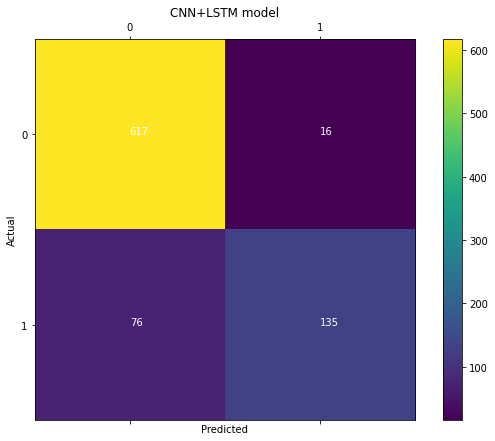

val_loss: 0.1610240489244461
test_loss: 0.2736242115497589
test_acc: 0.8909952640533447
precision: 0.8940397350993378
recall: 0.6398104265402843
specificity 0.9747235387045814
sensitivity :  0.6398104265402843
far 0.02527646129541864
frr 0.36018957345971564


In [36]:
# model CNN-LSTM    
inputs = tf.keras.Input(shape = (480, 2))
conv_1 = tf.keras.layers.Conv1D(filters = 4, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(inputs)
max_1 = tf.keras.layers.MaxPool1D(3)(conv_1)
    
# conv_2 = tf.keras.layers.Conv1D(filters = 179, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_1)
# max_2 = tf.keras.layers.MaxPool1D(3)(conv_2)
    
# conv_3 = tf.keras.layers.Conv1D(filters = 37, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_2)
# max_3 = tf.keras.layers.MaxPool1D(3)(conv_3)
    
D_out_1 = tf.keras.layers.Dropout(0.27506014989460326)(max_1)
    
lstm_1 = tf.keras.layers.LSTM(39)(D_out_1)
    
dense_1 = tf.keras.layers.Dense(11, activation = 'relu')(lstm_1)
# dense_2 = tf.keras.layers.Dense(42, activation = 'relu')(dense_1)
dense_3 = tf.keras.layers.Dense(1, activation = 'sigmoid')(dense_1)
    
model = tf.keras.models.Model(inputs = inputs, outputs = dense_3)

# Adam
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(0.00287010197769885), metrics = ['accuracy'])
# SGD
# model.compile(loss= 'binary_crossentropy', optimizer= tf.keras.optimizers.SGD(learning_rate=0.0009343048185018842, momentum=0.9379592661454418), metrics=['accuracy'])
    
# EarlyStopping 조기종료 및 모델 학습
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 20)
check_point = MyModelCheckpoint('best_model_' + str(sub_num + 1) + '.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)

# EarlyStopping 사용
hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [early_stopping, check_point])
# EarlyStopping 미사용
# hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [check_point])

# model save .h5형식
model = tf.keras.models.load_model('best_model_' + str(sub_num + 1) + '.h5')
model.save('Binary_BOHB_' + str(sub_num + 1) + '.h5')
model.summary() 
        
val_loss, val_acc = model.evaluate(val_data_set, val_label_set, verbose = 2)

test_loss, test_acc = model.evaluate(test_data_n, test_label, verbose = 2)
test_pred = model.predict(test_data_n)
        
    
# 각 행은 1sec, 0.5 <= 자신, 0.5 > 타인
for i in range(len(test_pred)):
    if(test_pred[i] >= 0.5):
        test_pred[i] = 1
    
    else: 
        test_pred[i] = 0
    
    
val_loss_all.append(val_loss)
    
test_loss_all.append(test_loss)
test_acc_all.append(test_acc)
test_pre_all.append(test_pred)
    

conf_matrix = confusion_matrix(test_label, test_pred) 
conf_matrix_sco.append(conf_matrix)
    
conf_row = conf_matrix.sum(axis = 1)
conf_col = conf_matrix.sum(axis = 0)

precision = conf_matrix[1][1] / conf_col[1]
recall = conf_matrix[1][1] / conf_row[1]
specificity = conf_matrix[0][0] / conf_row[0]
sensitivity = conf_matrix[1][1] / conf_row[1]
frr = conf_matrix[1][0] / (conf_matrix[1][1]+conf_matrix[1][0])
far = conf_matrix[0][1] / (conf_matrix[0][1]+conf_matrix[0][0])
    
frr_all.append(frr)
far_all.append(far)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

cax = ax.matshow(conf_matrix)

fig.colorbar(cax)

for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j], color="white")

plt.title('CNN+LSTM model')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()
 
    
test_pre_sco.append(precision)
test_rec_sco.append(recall)
test_spedi_sco.append(specificity)
test_sensi_sco.append(sensitivity)
    
print('val_loss:', val_loss)
print('test_loss:', test_loss)
print('test_acc:', test_acc)
    
print('precision:', precision)
print('recall:', recall)
print('specificity', specificity)
print('sensitivity : ', sensitivity)
print('far', far)
print('frr', frr)